In [82]:
import numpy as np
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count

In [83]:
# # loading in data 
# time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
# time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T

# strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
# strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])

# plt.plot(time_data,strain_data)

In [84]:
# # rolling to the middle and windowing and rolling back to 8 seconds
# mid_point = len(strain_data) //2
# final_point = len(strain_data)
# peaks,_ = find_peaks(strain_data,height = 6.86e-21,distance = 1000)

# plt.plot(strain_data)
# plt.title('Checking the peak is at the approx place')
# plt.show()
# print('The peak of the strain is located at',peaks)

# roll_amount = mid_point - peaks
# centred = np.roll(strain_data,int(roll_amount))
# delta_t = time_data[1] - time_data[0]
# window = signal.windows.hann(len(centred))
# centred_windowed_signal = centred*window
# signal_sorted = centred = np.roll(centred_windowed_signal,-int(roll_amount))

# # plt.plot(signal_sorted)
# # plt.title('Making sure the peak is centred and windowed')

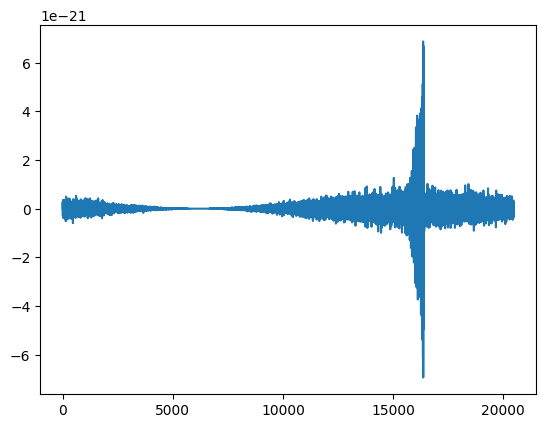

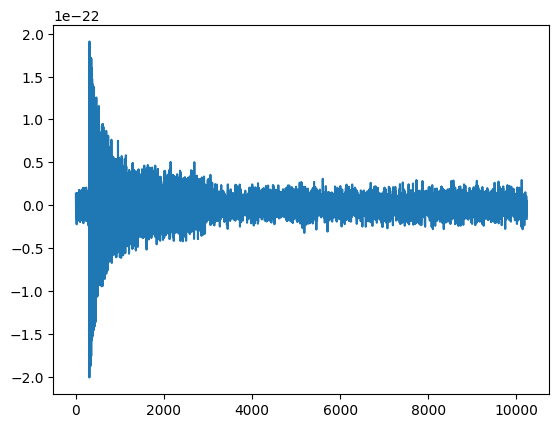

In [132]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T


# converting to time series
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))
plt.plot(centred_windowed_signal_final)
plt.show()
#defining main data and shaping
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)
plt.plot(data_freq*delta_t)
delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 1000/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 


In [133]:
def template(theta,delta_t,f_lower,f_higher,delta_f):
    M1,M2,D,time_shift = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M2,distance = D,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)
    # temp_cropped = hplus.crop(left = 4 , right = 2)
    # temp = np.fft.rfft(temp_cropped)

    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        # window_temp = signal.windows.hann(len(hplus))
        # temp = hplus*window_temp
        return hplus
    
    # below is code to fix it but dont think i should have it.
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

[-0.+0.j  0.-0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]


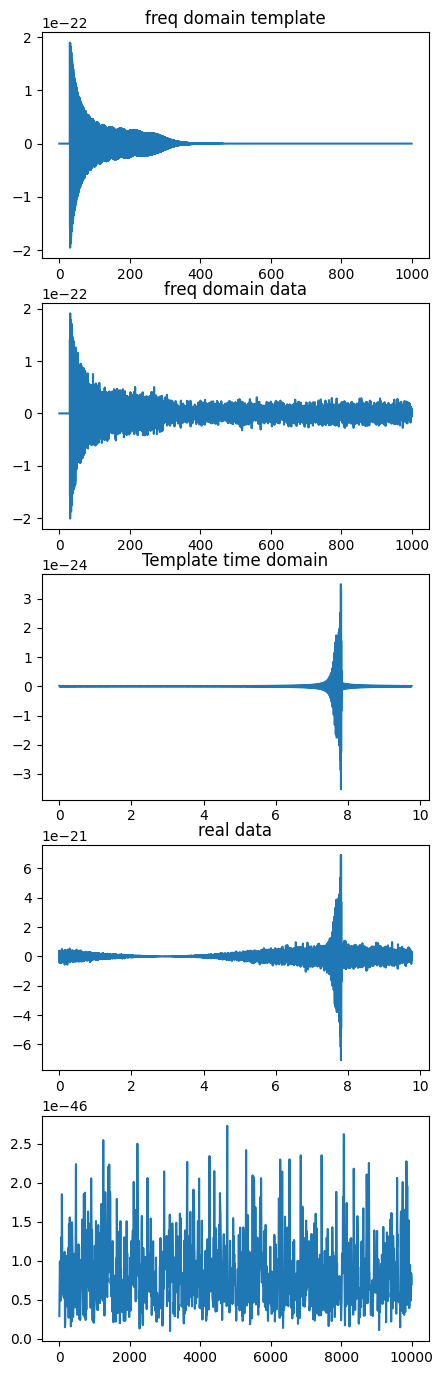

In [221]:
theta = 32,30,100,8
temp = template(theta,delta_t,30,1000,delta_f)#0.00873
print(temp)
# print(temp)
plt.figure(figsize = (5,17))
plt.subplot(511)
plt.plot(freq_final,temp)
plt.title('freq domain template')

plt.subplot(512)
plt.plot(freq_final, data_final*delta_t)
plt.title('freq domain data')

plt.subplot(513)
plt.plot(time_data[:20000],np.fft.irfft(temp))
plt.title('Template time domain')

plt.subplot(514)
plt.plot(time_data[:20000],np.fft.irfft(data_final))
plt.title('real data')

plt.subplot(515)
plt.plot(psd_interpolated)

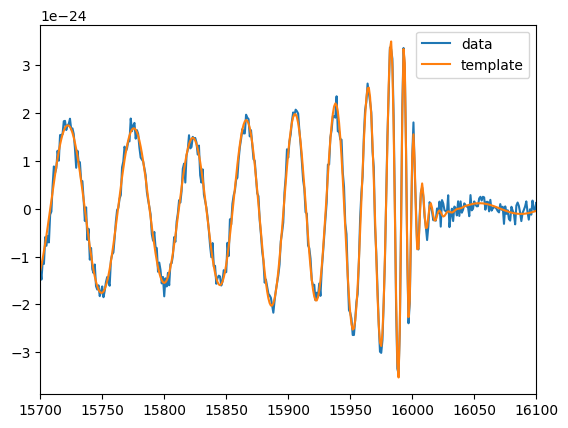

In [222]:
plt.plot((np.fft.irfft(data_final*delta_t)),label = 'data')
# plt.plot(np.fft.irfft(temp* np.exp(-2*np.pi*1j*freq_final*((18/2048)+8))),label = 'template')
plt.plot(np.fft.irfft(temp),label = 'template')
plt.xlim(15700,16100)
plt.legend()

In [ ]:
def log_prior(theta):
    M1,M2,D,time_shift = theta
    
    if not (30 < M1 < 34):
        return -np.inf
    
    if not (28 < M2 < 32):
        return -np.inf
    
    if not(70 < D < 120):
        return -np.inf
    
    if not(7.98< time_shift < 8.02):
        return -np.inf
    
    return 0.0 + 2*np.log(D)


In [260]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1000,delta_f)

    residual = fft_signal*delta_t - temp#*delta_t
    sum = np.abs(residual)**2/noise
    return -2 / 10 * np.sum((sum))

In [262]:
theta = 32,30,110,8
print(log_like(theta, data_final,psd_interpolated,delta_t,delta_f))

-4902.871145911873


In [258]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

In [263]:
theta = 32,30,110,8
print(log_posterior(theta, data_final,psd_interpolated,delta_t,delta_f))



-4893.470185180288


In [264]:
# defining the number of walkers in the mcmc chain and th number of dimensions (parameters)
nwalkers = 32
ndim = 4

# defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
initial[:, 1] = np.random.uniform(28, 32, size = nwalkers)#initial[:, 0])
initial[:, 2] = np.random.uniform(70, 120, size=nwalkers)
initial[:,3] = np.random.uniform(7.98,8.02, size = nwalkers)

#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 1000,progress = True)
sampler.reset()
# running the mcmc

nsteps = 1500
sampler.run_mcmc(initial, nsteps,progress = True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1500/1500 [08:56<00:00,  2.80it/s]


State([[ 32.01436253  29.96248291  99.88647893   8.00001012]
 [ 31.09132439  30.93021545 100.12059118   7.9999624 ]
 [ 32.0898374   29.88134701  99.13994828   8.00000481]
 [ 31.38601177  30.62893752 100.6710475    7.99997941]
 [ 31.69295941  30.30414606  99.86334161   7.99998947]
 [ 31.9946906   30.00204461  99.51182033   7.99999969]
 [ 31.76545495  30.22892738  99.31860008   7.9999843 ]
 [ 31.49021088  30.5101524  100.10040333   7.99998991]
 [ 31.39068799  30.64865917  99.4912435    7.99998655]
 [ 32.01851437  29.97422057  99.94882714   7.99999217]
 [ 31.78394523  30.18870894 100.01557483   7.99998192]
 [ 31.81118407  30.15791678 100.30598445   7.99999546]
 [ 31.38596995  30.62746467 100.01367667   7.99998027]
 [ 31.04743144  30.96932418 100.87343754   7.99997919]
 [ 31.80936252  30.16135993  99.78687826   8.00000015]
 [ 31.40087883  30.59542245 100.50091609   7.99997253]
 [ 31.60157484  30.41691422  99.5117779    7.99998526]
 [ 31.54462759  30.44198173 100.1947421    7.99997922]
 [ 3

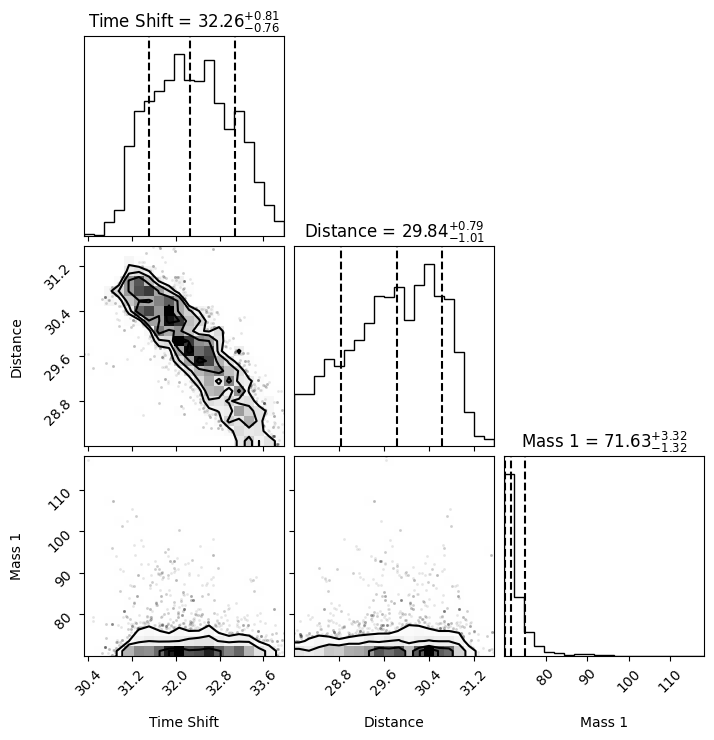

In [98]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['Time Shift','Distance','Mass 1','Mass 2'],quantiles=[0.16,0.5,0.84],show_titles = True)

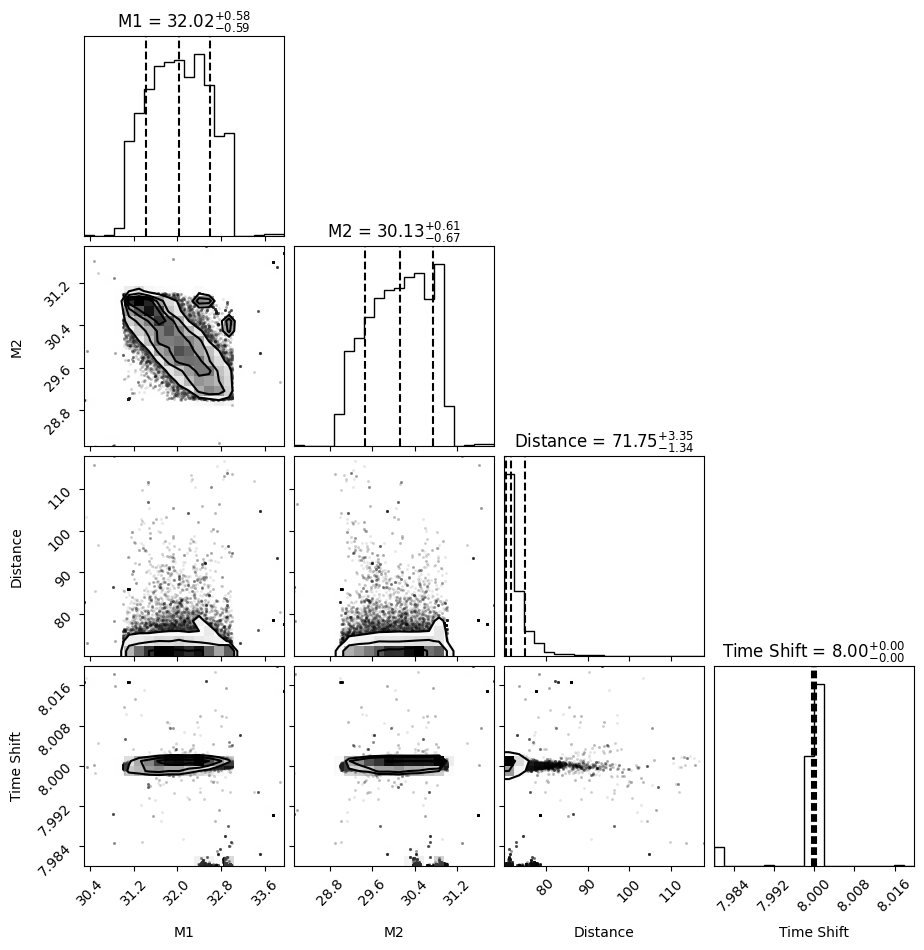

In [198]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)#,range=[(31.6, 32.4), (29.6, 30.4), (70, 120), (7.98,8.02)])

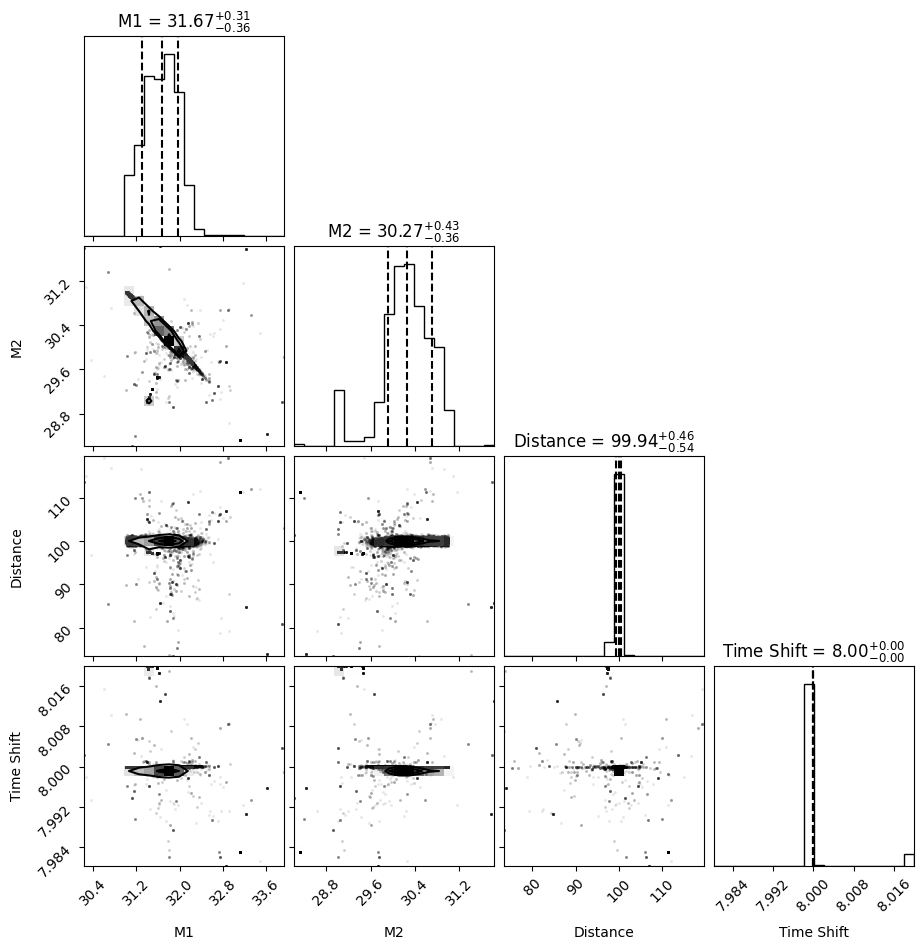

In [267]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)


figure.savefig("corner_plot_M1_M2_D_time.jpg", format="jpeg", dpi=300)